This notebook is to try out different architectures of NNs

In [15]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? н
Once deleted, variables cannot be recovered. Proceed (y/[n])? н
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
%run 'Functions.ipynb'

/nfs/scistore08/kondrgrp/eputints/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# 1. Training NN for a single chunk

In [5]:
min_max_scaler = MinMaxScaler()
n_iter = 500

chunk = 'S5'
print (chunk)
data, labels, unique_mutations[chunk], aa_seq, mutlist = read_data_all_positions(chunk)
np.random.shuffle(labels)

scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

model = Sequential()

model.add(Dense(2, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))
model.add(Dense(10, activation='sigmoid', kernel_initializer='glorot_normal'))

model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss='mean_squared_error')

hist = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                        epochs=n_iter, batch_size=500, shuffle=True)

proba = model.predict_proba(data, batch_size=500)

weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]

true = labels
predicted = min_max_scaler.inverse_transform(proba)
predicted = predicted.flatten()
fitness_potential = data.dot(weights) + biases

S5
Train on 50610 samples, validate on 512 samples
Epoch 1/500
50610/50610 [==============================] - 0s - loss: 0.0084 - val_loss: 0.0094
Epoch 2/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0080
Epoch 3/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0083
Epoch 4/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0078
Epoch 5/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0078
Epoch 6/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0078
Epoch 7/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0078
Epoch 8/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 9/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0078
Epoch 10/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_l

50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0079
Epoch 86/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0079
Epoch 87/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 88/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0078
Epoch 89/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 90/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0080
Epoch 91/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 92/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0080ss:
Epoch 93/500
50610/50610 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 94/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 95/500
50610/50610 [==============

50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 169/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 170/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 171/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 172/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 173/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0080
Epoch 174/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 175/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 176/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 177/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 178/500
50610/50610 [=======

50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 252/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 253/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 254/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 255/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 256/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 257/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0081
Epoch 258/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 259/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 260/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 261/500
50610/50610 [=======

50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 335/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 336/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 337/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 338/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 339/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 340/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0080
Epoch 341/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0080
Epoch 342/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 343/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 344/500
50610/50610 [=======

50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 418/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 419/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 420/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0081
Epoch 421/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 422/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 423/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 424/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 425/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 426/500
50610/50610 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0078
Epoch 427/500
50610/50610 [=======

42500/51122 [=======================>......] - ETA: 0s

In [12]:
weights.shape


(48, 2)

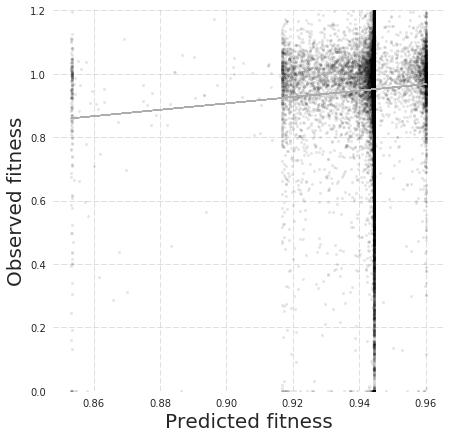

In [7]:
plt.figure(figsize = [7,7])
y = true
x = predicted
plt.ylim(0,1.2)

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.plot(x, y,'ok',alpha=0.1, ms=3)
plt.plot(x, a*x, '#abacac', lw=1, alpha=1)
plt.xlabel('Predicted fitness', fontsize=20)
plt.ylabel('Observed fitness', fontsize=20);

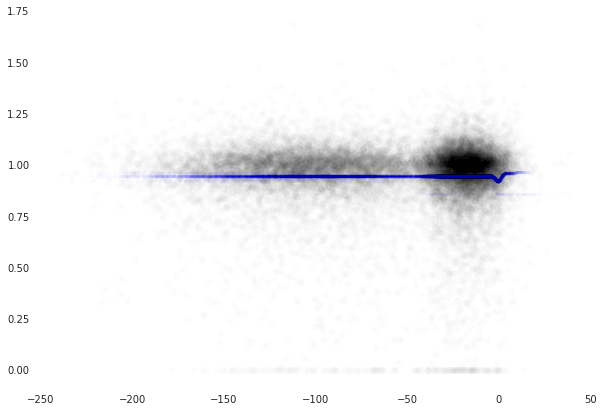

In [8]:
plt.figure(figsize = [10,7])
plt.plot(fitness_potential[:10000], true[:10000], 'ok', alpha = 0.01);
plt.plot(fitness_potential[:10000], predicted[:10000], '.b', alpha = 0.01);

In [9]:
slope, intercept, r_value, p_value, std_err = stats.linregress(true,predicted)
r_value

0.054585349912062535

***

In [ ]:
_,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
if R>0:
    fitness_potential[chunk]*=-1
    weights[chunk]*=-1

_,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
print chunk, '\t', R

### Selecting epistatic genotypes

In [583]:
chunk = 'S2'
data, labels, unique_mutations[chunk], aa_seq[chunk] = read_data_all_positions(chunk)

In [497]:
epi = pd.DataFrame.from_csv('../../lbcepistasisdropbox/' + chunk[1:] + '.tab', sep='\t')
epi['Mut'] = epi.VarPos.map(str) + epi.Perm

In [512]:
epistaticGenotypesPotential=[]
epistaticGenotypesFitness=[]

In [487]:
test = epi[(epi.Mut==list(set(epi.Mut))[7])&(epi.FitImpact>0)]
test = test.sort_values(by=['FitImpact'], ascending=False)

In [518]:
sq = 'SNRAFAVTKLGLQREKVGDLSSEMVPHV'
x = aa_seq[chunk]
ind = x[x==sq].index[0]
fp = data[ind].dot(weights[chunk])
f = labels[ind]
epistaticGenotypesPotential.append(fp)
epistaticGenotypesFitness.append(f)

In [511]:
for sq in test.Seq2[:100]:
    x = aa_seq[chunk]
    ind = x[x==sq].index[0]
    fp = data[ind].dot(weights[chunk])
    f = labels[ind]
    epistaticGenotypesPotential.append(fp)
    epistaticGenotypesFitness.append(f)

IndexError: index 0 is out of bounds for axis 0 with size 0

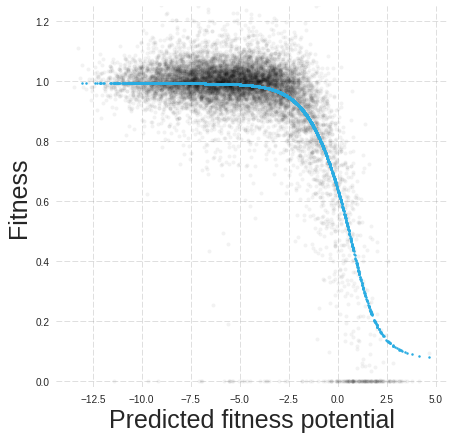

In [544]:
plt.figure(figsize = [7,7])
plt.plot(fitness_potential[chunk][:10000], true[chunk][:10000], 'ok', alpha = 0.05, ms=4);
plt.plot(fitness_potential[chunk][:5000], predicted[chunk][:5000], '.', color='#2AACE2', alpha = 1, ms=5)
# plt.plot(epistaticGenotypesPotential, epistaticGenotypesFitness,'o', color='#EA0A8C', alpha=0.8, ms=6)
plt.xlabel('Predicted fitness potential',fontsize=25)
plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.ylabel('Fitness',fontsize=25)
plt.ylim(-0.02,1.25);

In [578]:
chunk='S1'

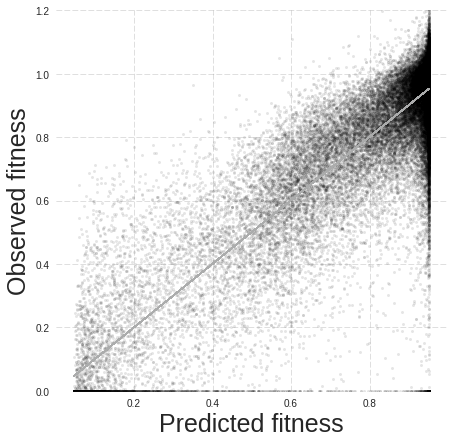

In [579]:
plt.figure(figsize = [7,7])
y = true[chunk]
x = predicted[chunk]
plt.ylim(0,1.2)

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.plot(x, y,'ok',alpha=0.1, ms=3)
plt.plot(x, a*x, '#abacac', lw=1, alpha=1)
plt.xlabel('Predicted fitness', fontsize=25)
plt.ylabel('Observed fitness', fontsize=25);

In [20]:
slope, intercept, r_value, p_value, std_err = stats.linregress(true[chunk],predicted[chunk])
r_value

/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

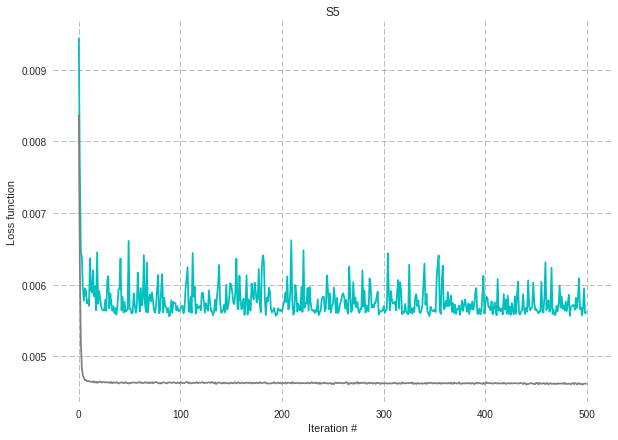

In [861]:
plt.figure(figsize=[10,7])
plt.title(chunk)
plt.plot([x for x in range(len(hist[chunk].history['loss']))], hist[chunk].history['val_loss'], 'c')
plt.plot([x for x in range(len(hist[chunk].history['loss']))], hist[chunk].history['loss'], 'gray')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Iteration #')
plt.ylabel('Loss function');

***

# 2. Training all the segments with the chosen architecture

#### 2.1. Training

In [7]:
true = {}
predicted = {}
fitness_potential = {}
hist = {}
weights = {}
old_weights = {}
biases = {}
aa_seq = {}
unique_mutations = {}
mutList = {}

In [8]:
min_max_scaler = MinMaxScaler()
n_iter = 500

for chunk in chunks:
    print (chunk)
    data, labels, unique_mutations[chunk], aa_seq[chunk] = read_data_all_positions(chunk)
    
    scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))
    
    x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)
    
    model = Sequential()

    model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))
    model.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  verbose=0)
        
    hist[chunk] = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                            epochs=n_iter, batch_size=500, shuffle=True, verbose=0)
    
    proba = model.predict_proba(data, batch_size=500, verbose=0)
    
    weights[chunk] = model.layers[0].get_weights()[0]
    biases[chunk] = model.layers[0].get_weights()[1]
    
    true[chunk] = labels
    predicted[chunk] = min_max_scaler.inverse_transform(proba)
    predicted[chunk] = predicted[chunk].flatten()
    fitness_potential[chunk] = data.dot(weights[chunk]) + biases[chunk]

S1
S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12


***

#### 2.2. Making sure that all fitness potentials correlate negatively with fitness by multiplying weights and fitness potentials by -1

In [9]:
for chunk in chunks:

    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    if R>0:
        fitness_potential[chunk]*=-1
        weights[chunk]*=-1
        
    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    print chunk, '\t', R

S1 	-0.784169276665
S2 	-0.791288189167
S3 	-0.818301882983
S4 	-0.8372955552
S5 	-0.599416079824
S6 	-0.806962161559
S7 	-0.827614291097
S8 	-0.820197626758
S9 	-0.937081498889
S10 	-0.901040926026
S11 	-0.88511964408
S12 	-0.688878860374


#### 2.3. Plotting

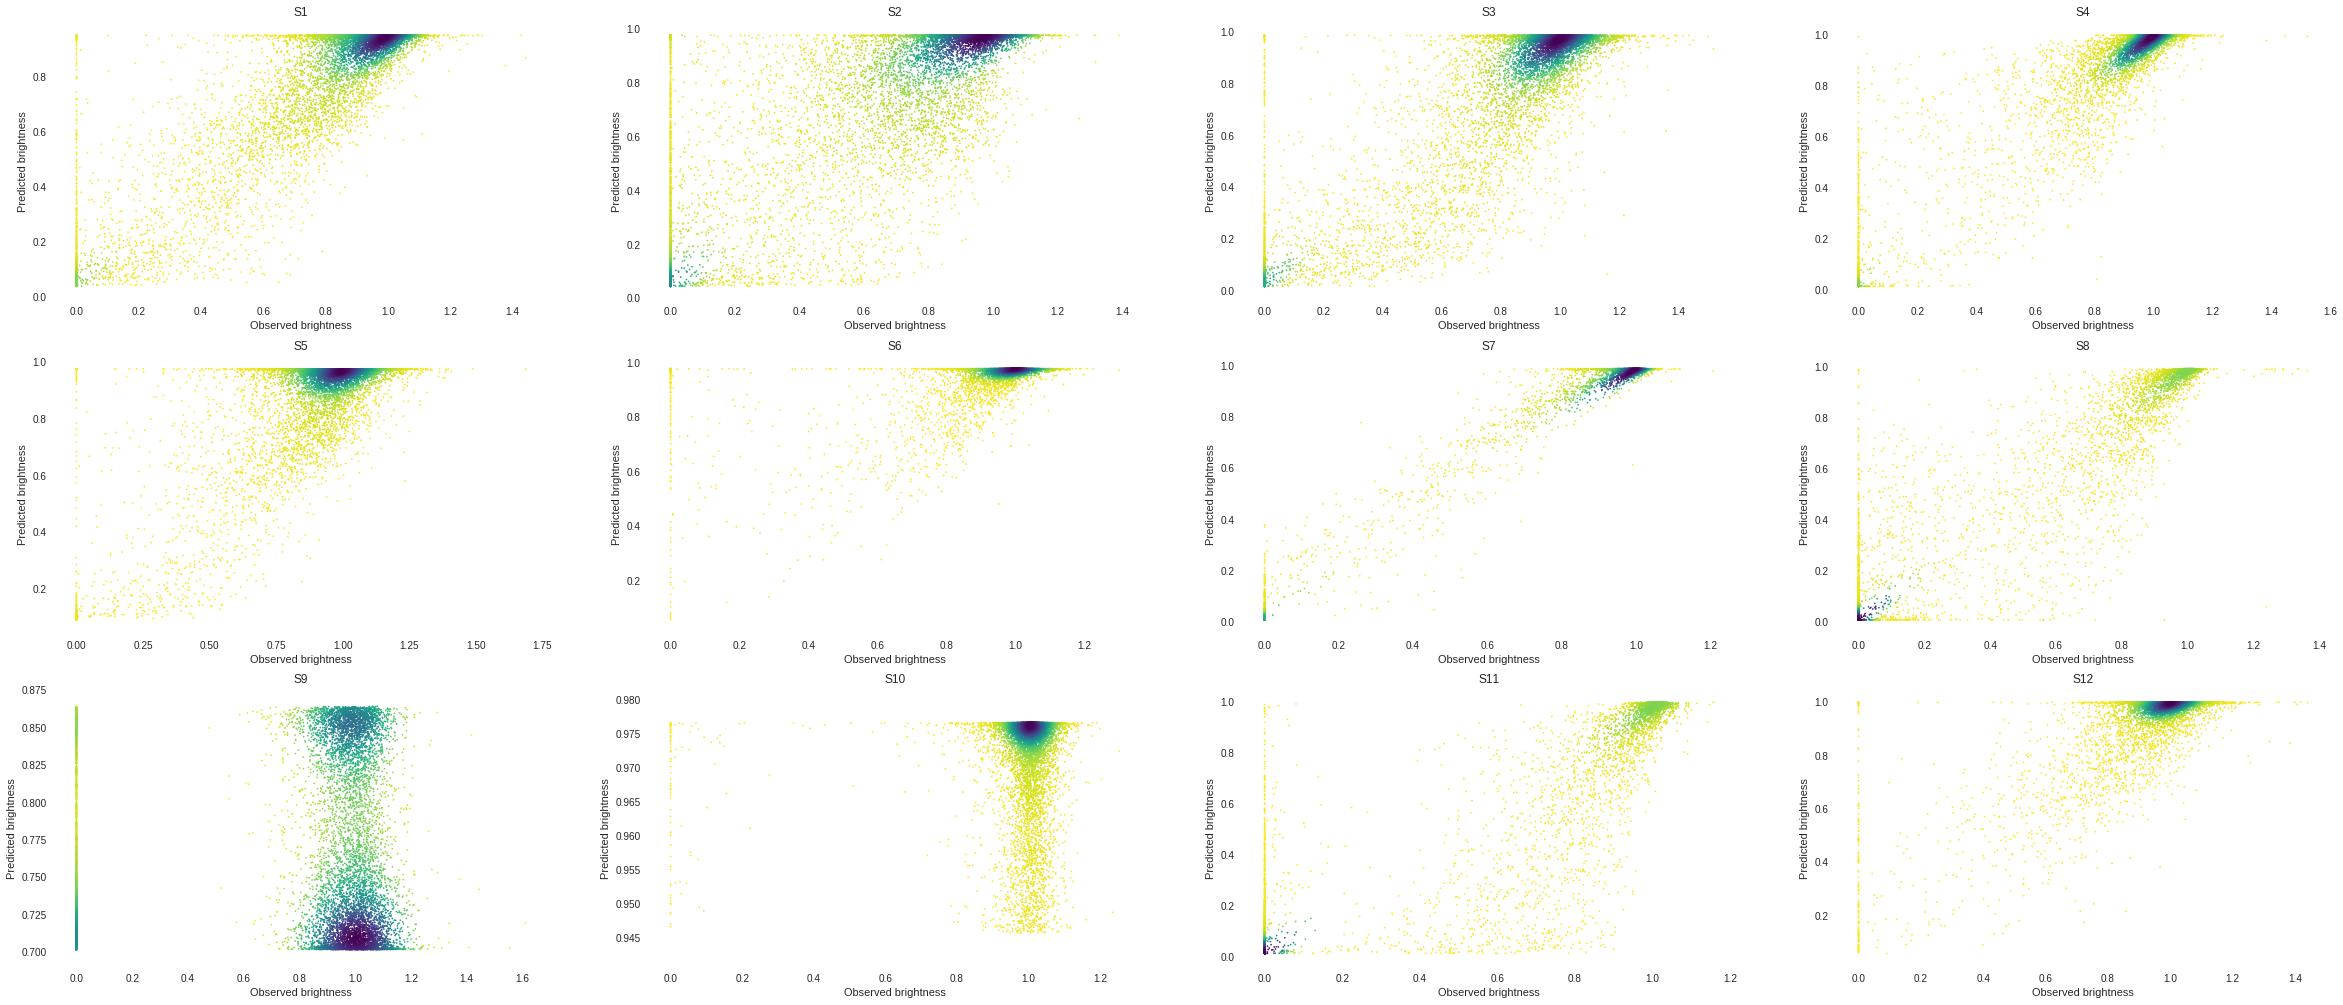

In [10]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
#     plt.ylim(0,1)
#     plt.xlim(0,1)
    density_plot(true[chunk][:10000], predicted[chunk][:10000], chunk)
    count+=1

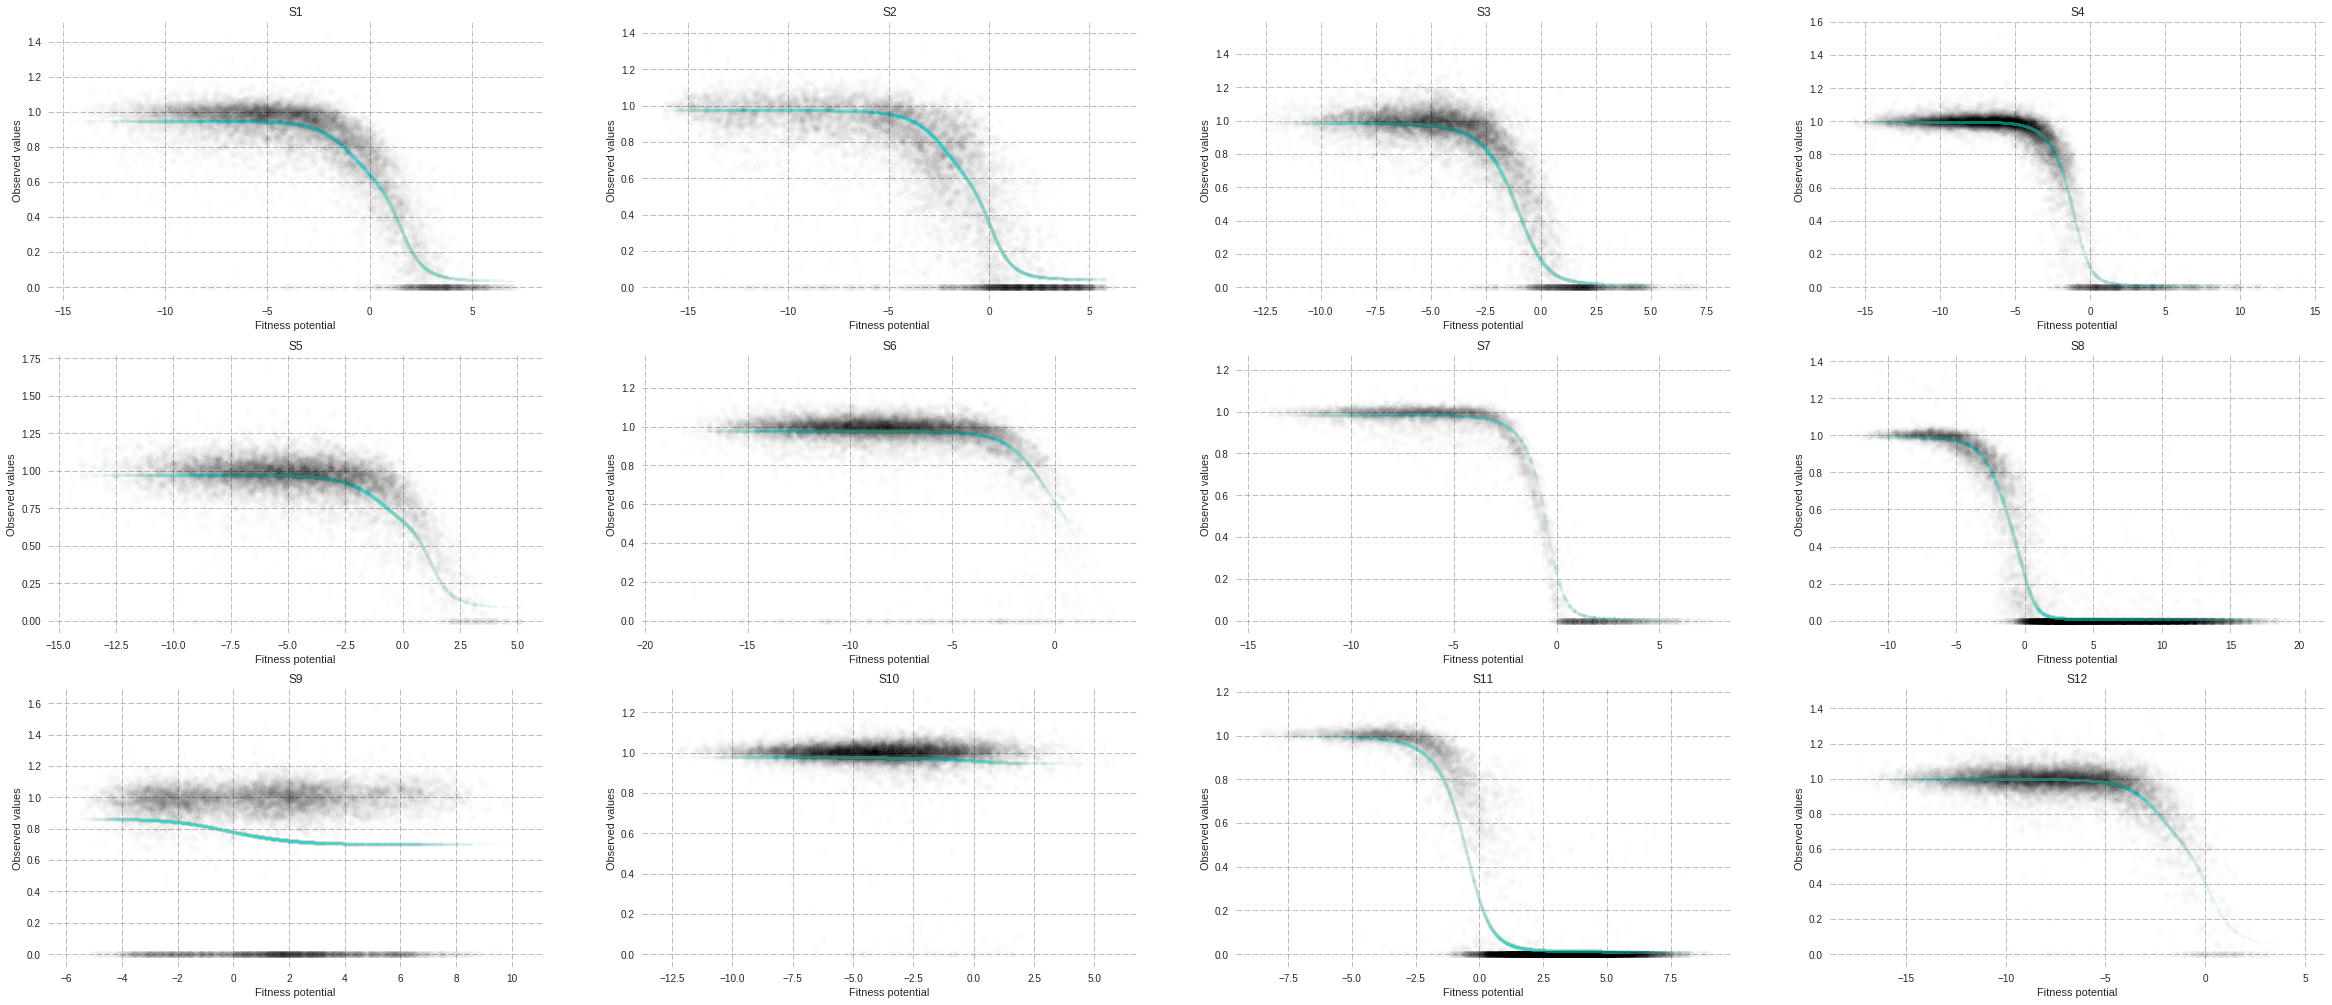

In [11]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    X = fitness_potential[chunk][:10000]
    Y = true[chunk][:10000]
    plt.plot(X, Y, 'ok', alpha = 0.01)
    plt.plot(X, predicted[chunk][:10000], '.', c='#36D1C4', alpha = 0.01)
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Fitness potential')
    plt.ylabel('Observed values')
    count+=1

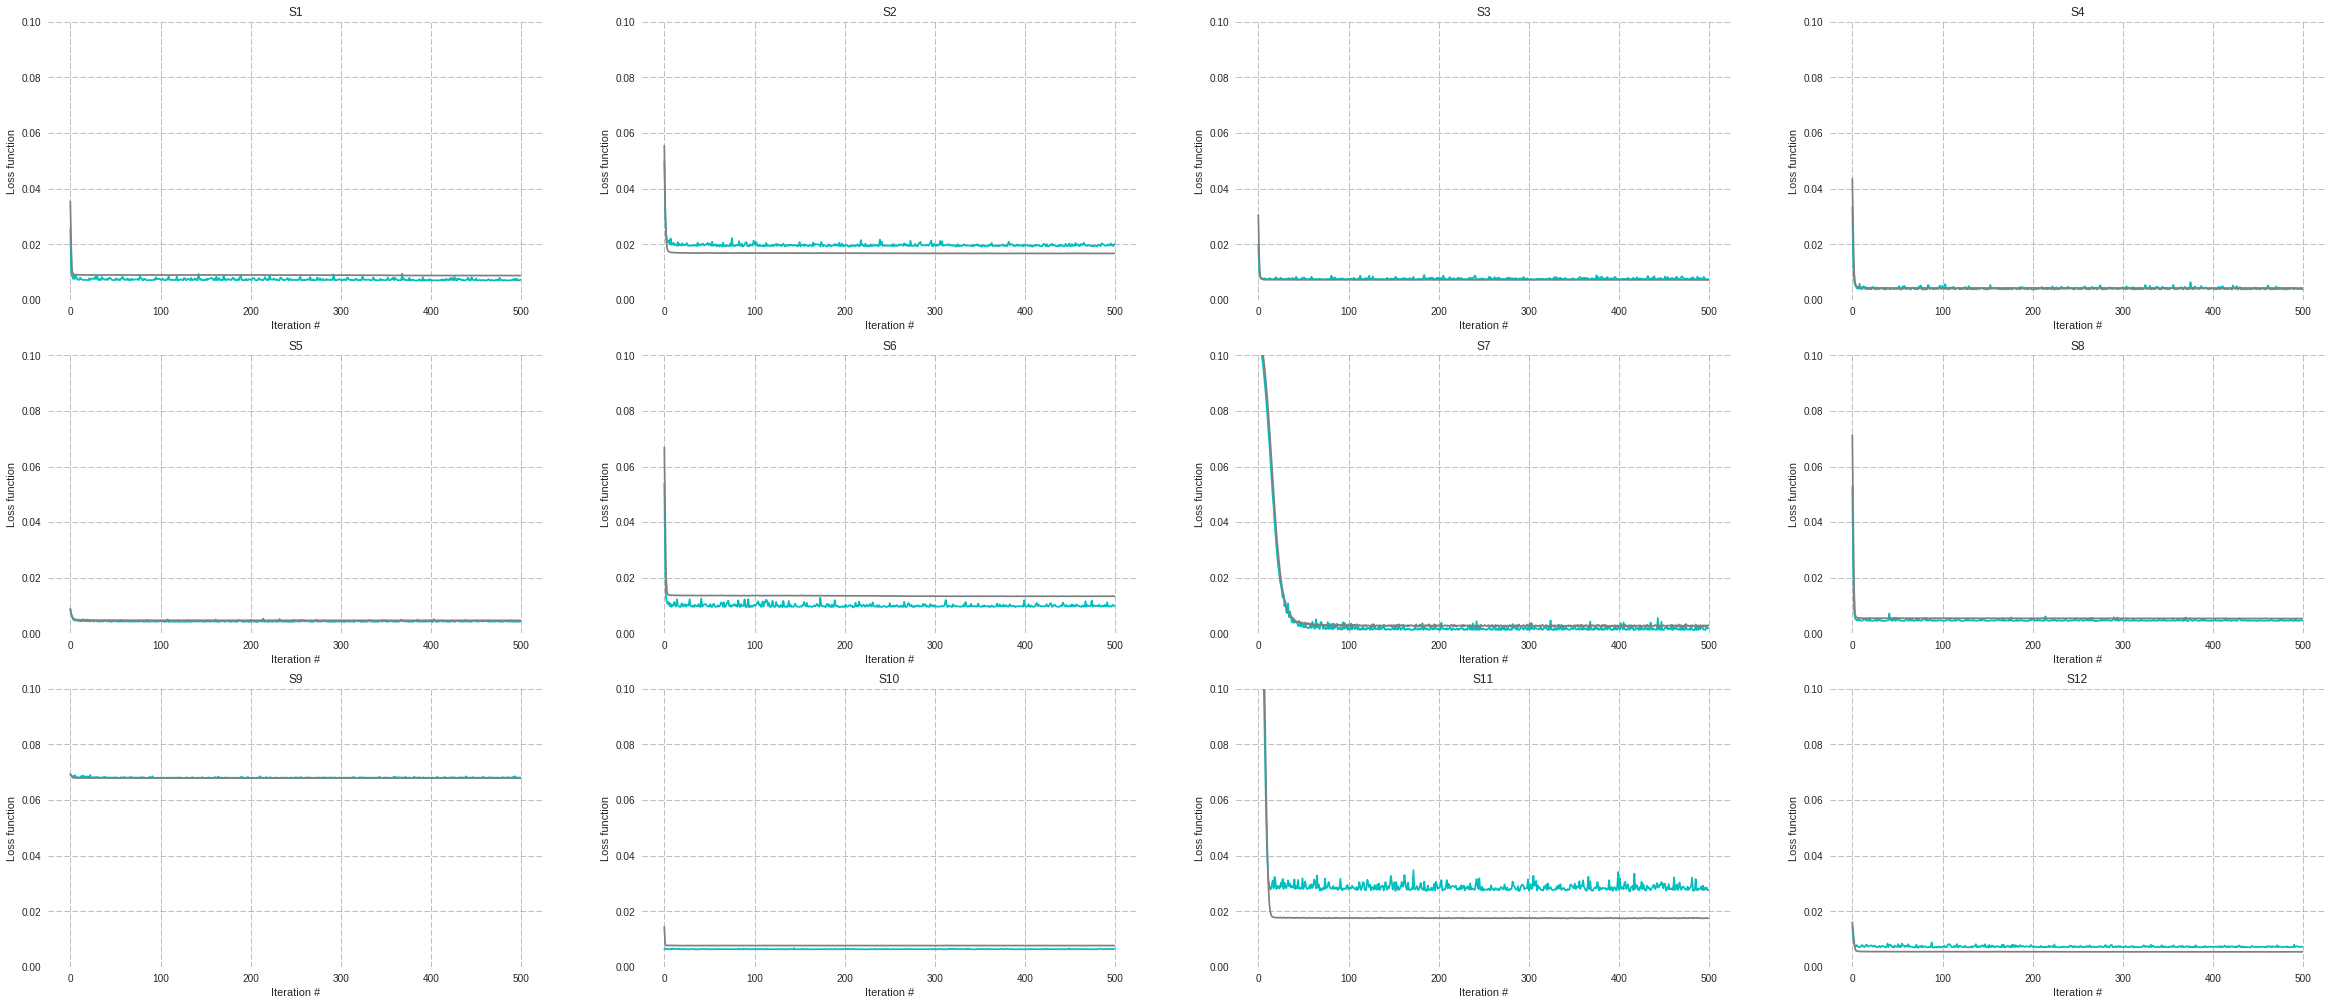

In [12]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.plot([x for x in range(len(hist[chunk].history['val_loss']))], hist[chunk].history['val_loss'], 'c')
    plt.plot([x for x in range(len(hist[chunk].history['val_loss']))], hist[chunk].history['loss'], 'gray')
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Iteration #')
    plt.ylabel('Loss function')
    plt.ylim(0, 0.1)
    count+=1

#### 2.4. Extracting residuals

In [22]:
residualsDF = {}

for chunk in chunks:
    residualsDF[chunk] = pd.DataFrame(predicted[chunk] - true[chunk], index = aa_seq[chunk])

    residualsDF[chunk]['fitnessPotential'] = fitness_potential[chunk]
    residualsDF[chunk]['observed'] = true[chunk]
    residualsDF[chunk].columns = ['predictedMinusObserved', 'fitnessPotential', 'observed']
    residualsDF[chunk].to_csv('../residuals/' + chunk + '.csv', sep=',')

#### 2.5. Extracting weights

In [23]:
weightsDF = {}

for chunk in chunks:
    weightsDF[chunk] = pd.DataFrame(weights[chunk], index = unique_mutations[chunk], columns=['weight'])
    weightsDF[chunk].to_csv('../weights/'+chunk+'.csv', sep=',')

# 3. Checking correlations and loss function

### 3.1. Correlations prediction vs observed + Lucas's values

In [13]:
r_values = []

for chunk in chunks:
    y = true[chunk]
    y_pred = predicted[chunk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,y_pred)
    r_values.append(r_value)
    
lucas = [0.76386, 0.62877, 0.80256, 0.91289, 0.49342, 0.15075, 0.97532, 0.88078, 0.01069, 0.0096183, 0.81741, 0.54172]

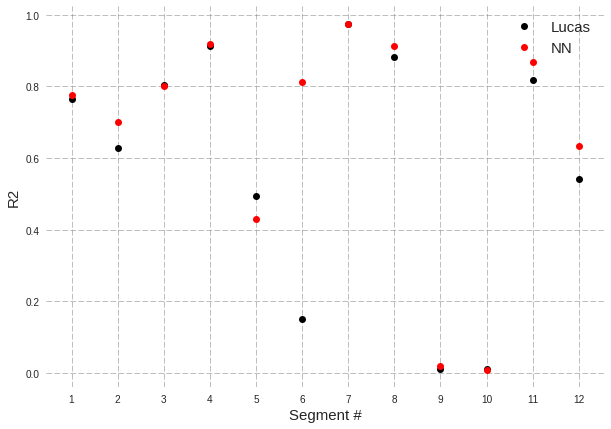

In [14]:
plt.figure(figsize=[10,7])
plt.plot([x for x in range(1, 13)], lucas, 'ok', label='Lucas')
plt.plot([x for x in range(1, 13)], [x**2 for x in r_values], 'or', label='NN')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Segment #', fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.ylabel('R2', fontsize=15)
plt.xticks([x for x in range(1,13)]);

In [33]:
zip(chunks,[x**2 for x in r_values])

[('S1', 0.7707586838609285),
 ('S2', 0.70162689952208124),
 ('S3', 0.80369152818401235),
 ('S4', 0.91817057246079459),
 ('S5', 0.43726825632776195),
 ('S6', 0.81242080070563449),
 ('S7', 0.97789617503919324),
 ('S8', 0.9114042225749629),
 ('S9', 0.017834040911872639),
 ('S10', 0.0098782096120834245),
 ('S11', 0.86882736397063087),
 ('S12', 0.62978102480501408)]

# 4. Crossvalidation

### 4.1. Comparing train and test sets predictions R2

In [35]:
rDictTrain = {}
rDictTest = {}

In [ ]:
min_max_scaler = MinMaxScaler()
n_iter = 500

for chunk in chunks:
    
    rDictTrain[chunk] = []
    rDictTest[chunk] = []
    
    print (chunk)
    
    for i in range(10):
        print (i)
        
        data, labels, unique_mutations[chunk], aa_seq[chunk] = read_data_all_positions(chunk)

        scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

        x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.05)

        model = Sequential()

        model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))
        model.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
        model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

        opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

        model.compile(optimizer=opt,
                      loss='mean_squared_error',
                      verbose=0)

        hist[chunk] = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                                epochs=n_iter, batch_size=500, shuffle=True, verbose=0)

        trainProba = model.predict_proba(x_train, batch_size=500, verbose=0)
        testProba = model.predict_proba(x_valid, batch_size=500, verbose=0)

        _,_,r,_,_ = stats.linregress(y_train.flatten(), trainProba.flatten())
        rDictTrain[chunk].append(r)

        _,_,r,_,_ = stats.linregress(y_valid.flatten(), testProba.flatten())
        rDictTest[chunk].append(r)         

S1
0
1
2
3
4
5
6
7
8
9
S2
0
1
2


In [116]:
from collections import OrderedDict
r2DictTest = OrderedDict()
for chunk in chunks:
    r2DictTest[chunk] = [r*r for r in rDictTest[chunk]]

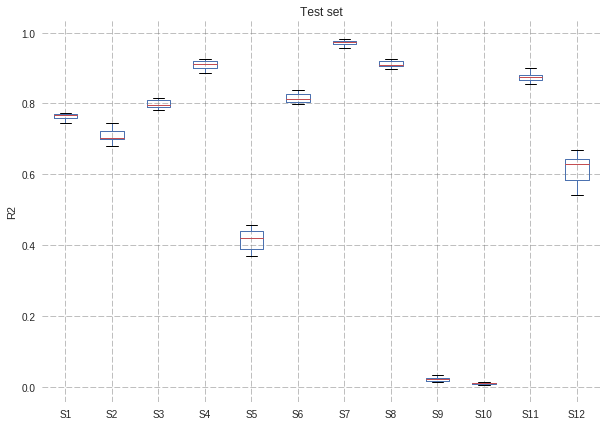

In [117]:
rTest = pd.DataFrame.from_dict(r2DictTest)
plt.figure(figsize=[10,7])
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.ylabel('R2')
plt.title('Test set')
rTest.boxplot();

In [114]:
r2DictTrain = OrderedDict()
for chunk in chunks:
    r2DictTrain[chunk] = [r*r for r in rDictTrain[chunk]]

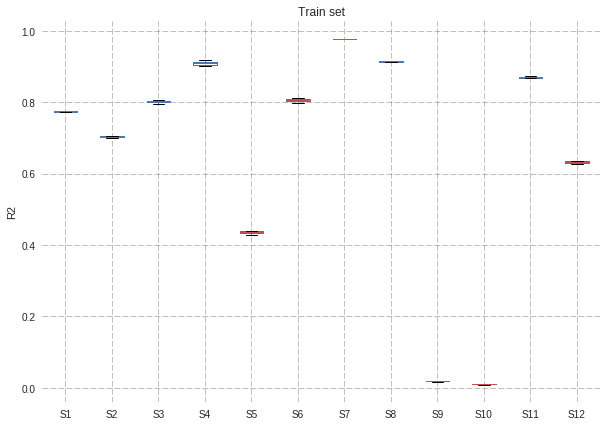

In [115]:
rTrain = pd.DataFrame.from_dict(r2DictTrain)
plt.figure(figsize=[10,7])
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.ylabel('R2')
rTrain.boxplot()
plt.title('Train set');

In [119]:
chunkCol = []
trainTestCol = []
r2Col = []

for chunk in chunks:
    chunkCol.extend([chunk]*len(r2DictTrain[chunk]))
    trainTestCol.extend(['train']*len(r2DictTrain[chunk]))
    r2Col.extend(r2DictTrain[chunk])
                        
    chunkCol.extend([chunk]*len(r2DictTest[chunk]))
    trainTestCol.extend(['test']*len(r2DictTest[chunk]))
    r2Col.extend(r2DictTest[chunk])    

In [120]:
r2DF = pd.DataFrame()

r2DF['chunk'] = chunkCol
r2DF['trainTest'] = trainTestCol
r2DF['R2'] = r2Col

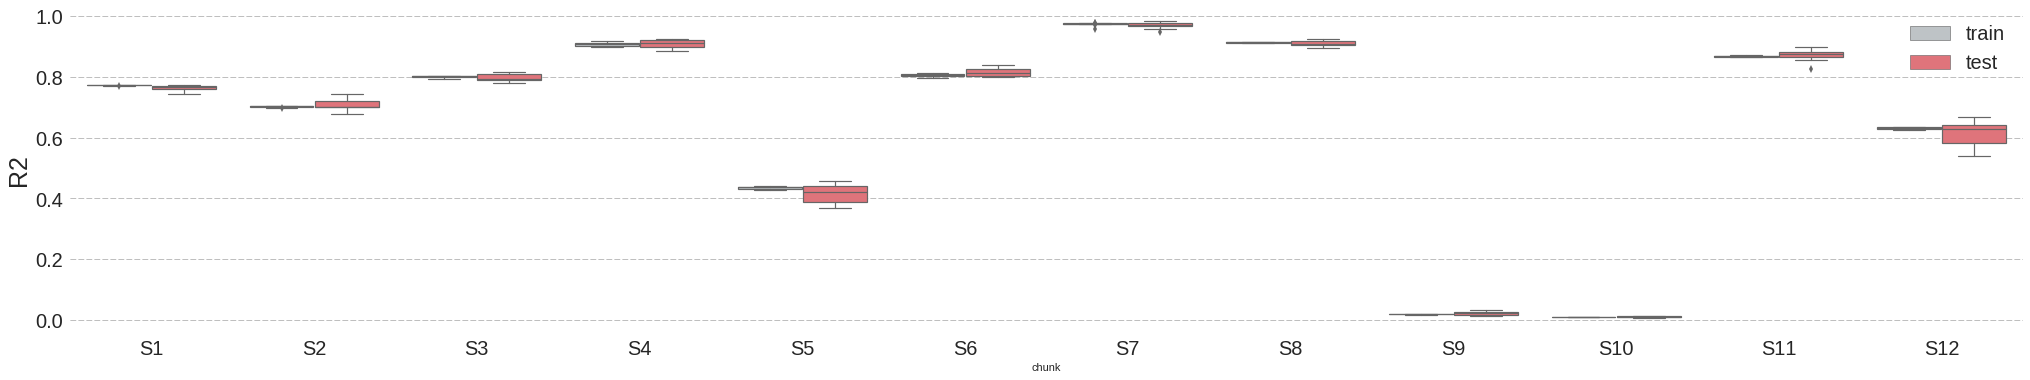

In [192]:
colors = ["#BDC3C7","#F1626C"]
x = sns.color_palette(colors)

plt.figure(figsize=[35,6])
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
sns.boxplot(x = r2DF.chunk, y = r2DF.R2, hue=r2DF.trainTest, palette=x, width=0.8, linewidth=1.2)
plt.legend(fontsize=20)
plt.ylabel('R2', fontsize=25)
plt.tick_params(labelsize=20);